In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Set random seeds for reproducibility
random.seed(21)
np.random.seed(21)
tf.random.set_seed(21)

In [ ]:
# Load your DataFrame
df = pd.read_csv('parsed_data_final.csv', index_col=0)

In [33]:
# Predicted label counts
label_counts = df['Label'].value_counts()
print("label counts:")
print(label_counts)

# Percentage of positive predictions
total_predictions = len(df)
num_positive = label_counts.get(1, 0)
percentage_positive = (num_positive / total_predictions) * 100
print(f"Percentage of instances predicted as positive: {percentage_positive:.2f}%")

label counts:
Label
0    116363
1      5475
Name: count, dtype: int64
Percentage of instances predicted as positive: 4.49%


In [19]:
print(df.head())

           Gene ID    Transcript ID  Position Nucleotide 1 Nucleotide 2  \
0  ENSG00000004059  ENST00000000233       244        AAGAC        AGACC   
1  ENSG00000004059  ENST00000000233       261        CAAAC        AAACT   
2  ENSG00000004059  ENST00000000233       316        GAAAC        AAACA   
3  ENSG00000004059  ENST00000000233       332        AGAAC        GAACA   
4  ENSG00000004059  ENST00000000233       368        AGGAC        GGACA   

  Nucleotide 3  N1 Length Avg  N1 Length Median  N1 Length Min  N1 Length Max  \
0        GACCA       0.008264           0.00697        0.00199         0.0339   
1        AACTG       0.006609           0.00564        0.00199         0.0222   
2        AACAG       0.007570           0.00631        0.00232         0.0299   
3        AACAT       0.010620           0.00902        0.00232         0.0370   
4        GACAA       0.010701           0.00896        0.00199         0.0478   

   ...  N3 Length Max  N3 SD Avg  N3 SD Median  N3 SD Min  N3 

In [20]:
# Ensure 'Gene ID' is treated as a string
df['Gene ID'] = df['Gene ID'].astype(str)

# Map nucleotides to integers
nucleotide_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'PAD': 4}

# Define the sequence encoding function
def encode_sequence(seq, mapping):
    return [mapping[nuc] for nuc in seq]

# Concatenate sequences
df['sequence'] = df['Nucleotide 1'] + df['Nucleotide 3'].str[-2:]

# Encode sequences
df['encoded_sequence'] = df['sequence'].apply(lambda x: encode_sequence(x, nucleotide_to_int))

# Determine the maximum sequence length
max_sequence_length = df['encoded_sequence'].apply(len).max()

# Pad sequences
df['padded_sequence'] = list(
    pad_sequences(
        df['encoded_sequence'],
        maxlen=max_sequence_length,
        padding='post',
        value=nucleotide_to_int['PAD']
    )
)

# Identify numerical columns
exclude_cols = [
    'Gene ID', 'Transcript ID', 'Position',
    'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3',
    'sequence', 'encoded_sequence', 'padded_sequence', 'Label'
]
numerical_cols = [col for col in df.columns if col not in exclude_cols]


In [21]:
print(numerical_cols)
# In training
#numerical_cols_train = numerical_cols  # Save this list after defining it
print(len(numerical_cols))

['N1 Length Avg', 'N1 Length Median', 'N1 Length Min', 'N1 Length Max', 'N1 SD Avg', 'N1 SD Median', 'N1 SD Min', 'N1 SD Max', 'N1 Mean Avg', 'N1 Mean Median', 'N1 Mean Min', 'N1 Mean Max', 'N2 Length Avg', 'N2 Length Median', 'N2 Length Min', 'N2 Length Max', 'N2 SD Avg', 'N2 SD Median', 'N2 SD Min', 'N2 SD Max', 'N2 Mean Avg', 'N2 Mean Median', 'N2 Mean Min', 'N2 Mean Max', 'N3 Length Avg', 'N3 Length Median', 'N3 Length Min', 'N3 Length Max', 'N3 SD Avg', 'N3 SD Median', 'N3 SD Min', 'N3 SD Max', 'N3 Mean Avg', 'N3 Mean Median', 'N3 Mean Min', 'N3 Mean Max']
36


# train-test split

In [22]:
# Perform group-wise train-test split
train_list = []
test_list = []

grouped = df.groupby('Gene ID')

for gene_id, group in grouped:
    n_samples = len(group)
    
    if n_samples >= 2:
        train, test = train_test_split(group, test_size=0.3, random_state=42)
    else:
        train = group
        test = pd.DataFrame(columns=group.columns)
    
    if not train.empty:
        train_list.append(train)
    if not test.empty:
        test_list.append(test)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=10).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=10).reset_index(drop=True)



In [23]:
# Handle class imbalance on the training data
# Separate minority and majority classes in training data
minority_class = train_df[train_df['Label'] == 1]
majority_class = train_df[train_df['Label'] == 0]

# Count samples in each class
num_minority = len(minority_class)
num_majority = len(majority_class)

print(f'Number of minority samples in training data: {num_minority}')
print(f'Number of majority samples in training data: {num_majority}')

# Calculate desired number of minority samples for 1:2 ratio
desired_minority_count = int(num_majority / 2)

# Oversample the minority class
minority_oversampled = minority_class.sample(
    n=desired_minority_count,
    replace=True,
    random_state=42
)

# Combine oversampled minority class with majority class
train_balanced = pd.concat([majority_class, minority_oversampled], ignore_index=True)

# Shuffle the training data
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution after oversampling
print('Class distribution after adjusted oversampling:')
print(train_balanced['Label'].value_counts())

# Prepare inputs from the balanced training data
X_seq_train = np.stack(train_balanced['padded_sequence'].values)
X_num_train = train_balanced[numerical_cols].values
y_train = train_balanced['Label'].values

# Prepare inputs from the test data (unchanged)
X_seq_test = np.stack(test_df['padded_sequence'].values)
X_num_test = test_df[numerical_cols].values
y_test = test_df['Label'].values

# Normalize numerical features using training data statistics
scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)

# Save the fitted scaler
joblib.dump(scaler, 'scaler.joblib')

Number of minority samples in training data: 3723
Number of majority samples in training data: 79887
Class distribution after adjusted oversampling:
Label
0    79887
1    39943
Name: count, dtype: int64


['scaler.joblib']

In [24]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))



In [25]:
# Define embedding dimension
embedding_dim = 8  # Adjust as needed

# Build your model
sequence_input = tf.keras.Input(shape=(max_sequence_length,), name='sequence_input')
numerical_input = tf.keras.Input(shape=(X_num_train.shape[1],), name='numerical_input')

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(nucleotide_to_int),
    output_dim=embedding_dim,
    input_length=max_sequence_length,
    name='embedding_layer'
)(sequence_input)

lstm_out = tf.keras.layers.LSTM(128)(embedding_layer)

combined_features = tf.keras.layers.Concatenate()([lstm_out, numerical_input])

x = tf.keras.layers.Dense(64, activation='relu')(combined_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[sequence_input, numerical_input], outputs=output)



In [26]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='roc_auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)



In [27]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_roc_auc',  # Change to 'val_loss' or another metric if preferred
    mode='max',
    patience=5,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    [X_seq_train, X_num_train],
    y_train,
    epochs= 30,  
    batch_size=32,
    class_weight=class_weight_dict,
    validation_data=([X_seq_test, X_num_test], y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
3745/3745 [==============================] - 19s 5ms/step - loss: 0.4976 - accuracy: 0.7616 - roc_auc: 0.8410 - pr_auc: 0.7295 - val_loss: 0.4341 - val_accuracy: 0.8078 - val_roc_auc: 0.8868 - val_pr_auc: 0.4036
Epoch 2/30
3745/3745 [==============================] - 17s 5ms/step - loss: 0.4280 - accuracy: 0.8119 - roc_auc: 0.8872 - pr_auc: 0.8048 - val_loss: 0.3496 - val_accuracy: 0.8637 - val_roc_auc: 0.8989 - val_pr_auc: 0.4375
Epoch 3/30
3745/3745 [==============================] - 17s 5ms/step - loss: 0.4070 - accuracy: 0.8236 - roc_auc: 0.8984 - pr_auc: 0.8204 - val_loss: 0.3546 - val_accuracy: 0.8595 - val_roc_auc: 0.9037 - val_pr_auc: 0.4504
Epoch 4/30
3745/3745 [==============================] - 17s 5ms/step - loss: 0.3945 - accuracy: 0.8265 - roc_auc: 0.9047 - pr_auc: 0.8293 - val_loss: 0.3941 - val_accuracy: 0.8197 - val_roc_auc: 0.9048 - val_pr_auc: 0.4480
Epoch 5/30
3745/3745 [==============================] - 17s 5ms/step - loss: 0.3840 - accuracy: 0.8304 - roc

In [28]:
# Evaluate the model on the test data
loss, accuracy, roc_auc_metric, pr_auc_metric = model.evaluate([X_seq_test, X_num_test], y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print(f'Test ROC AUC: {roc_auc_metric}')
print(f'Test PR AUC: {pr_auc_metric}')

# Obtain predicted probabilities
y_pred_proba = model.predict([X_seq_test, X_num_test]).ravel()

# Compute additional metrics using scikit-learn
# Convert predicted probabilities to binary class labels
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Compute Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred_class, zero_division=0)
recall = recall_score(y_test, y_pred_class, zero_division=0)
f1 = f1_score(y_test, y_pred_class, zero_division=0)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')



1195/1195 [==============================] - 2s 2ms/step - loss: 0.3300 - accuracy: 0.8399 - roc_auc: 0.9072 - pr_auc: 0.4691
Test Loss: 0.32997244596481323
Test Accuracy: 0.8399079442024231
Test ROC AUC: 0.9071838855743408
Test PR AUC: 0.46912264823913574
1195/1195 [==============================] - 2s 2ms/step
Precision: 0.1976
Recall: 0.8145
F1 Score: 0.3180


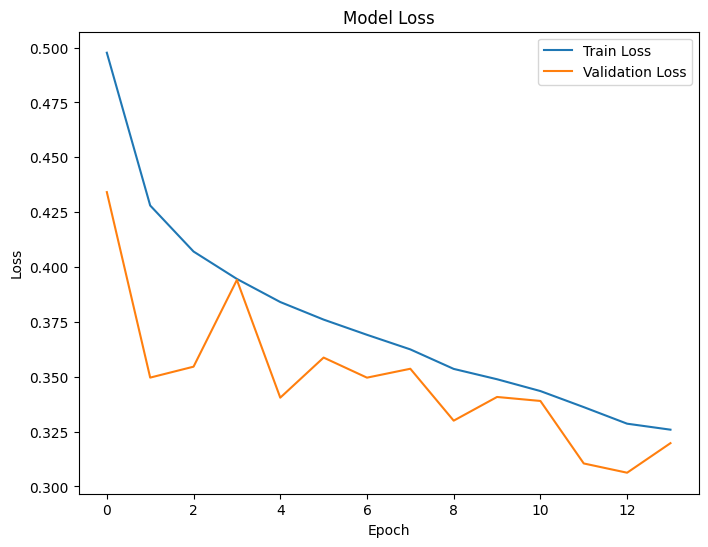

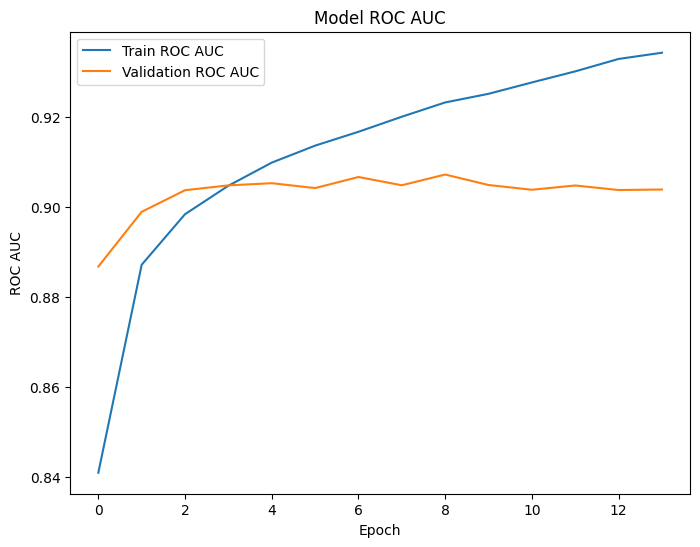

In [29]:
# Plot training & validation loss values
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation ROC AUC values
plt.figure(figsize=(8,6))
plt.plot(history.history['roc_auc'], label='Train ROC AUC')
plt.plot(history.history['val_roc_auc'], label='Validation ROC AUC')
plt.title('Model ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

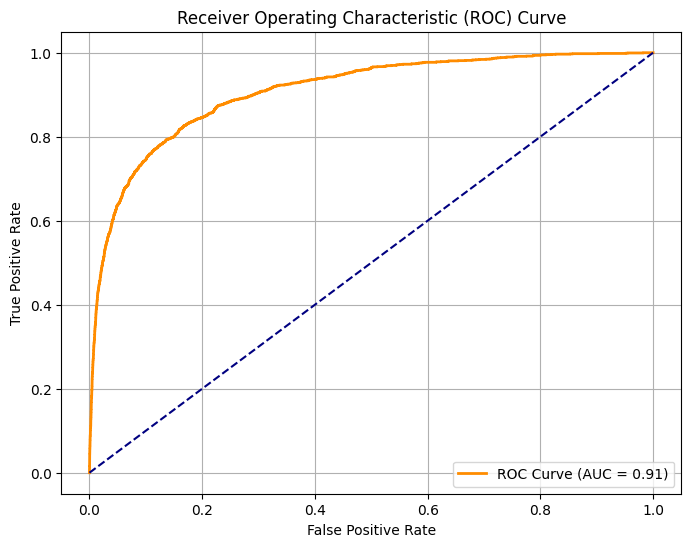

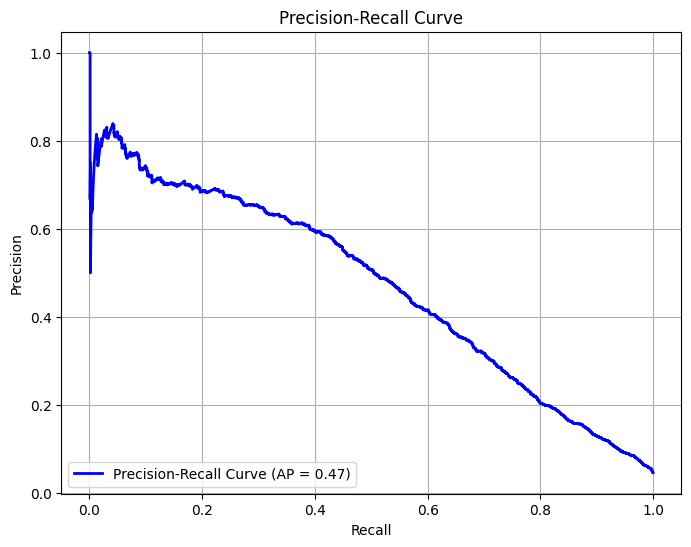

In [30]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_metric:.2f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall Curve (AP = {pr_auc_metric:.2f})', color='blue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [31]:
# Save the entire model in the TensorFlow SavedModel format
model.save('rnn_model')

INFO:tensorflow:Assets written to: rnn_model/assets


INFO:tensorflow:Assets written to: rnn_model/assets


In [32]:
# Save max_sequence_length
with open('max_sequence_length.txt', 'w') as f:
    f.write(str(max_sequence_length))
